In [16]:
import pandas as pd
from tqdm import tqdm
from database.market import Market
from database.sim import Sim
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
import numpy as np
import statistics
from sklearn.preprocessing import normalize

In [17]:
strat_db = Sim("sim")
market = Market("market")
market.connect()
sp5 = market.retrieve_data("sp500")
market.close()
strat_db.connect()
tse = strat_db.retrieve_data("epochs")
strat_db.close()

In [18]:
seats = 20
tsmc = "full"
strat_db.connect()
analysis = []
for epoch in tse["epoch"].unique():
    epoch_dict = tse.iloc[epoch]
    trades = strat_db.retrieve_data("trades_{}".format(epoch))
    if trades.index.size < 1:
        continue
    else:
        for seat in range(1,seats+1):
            initial = 100/seats
            seat_trades = trades[trades["seat"] == seat]
            if seat_trades.index.size > 0:
                for delta in seat_trades["sell_delta"]:
                    initial = initial * (1 + delta)
                stg = seat_trades.groupby("seat").mean().reset_index()[["adjclose","sell_price","seat","sell_delta"]]
                stg["epoch"] = epoch
                stg["hpr"] = statistics.mean([(row[1]["sell_date"] - row[1]["date"]).days for row in seat_trades.iterrows()])
                stg["wdr"] = epoch_dict["delta_req"]
                stg["pv"] = initial
                stg["trades"] = seat_trades.index.size
                stg["winrate"] = seat_trades[seat_trades["sell_delta"] > 0].index.size / seat_trades.index.size
                stg["delta"] = seat_trades["sell_delta"].mean()
                analysis.append(stg)
strat_db.close()

In [19]:
a = pd.concat(analysis)
metric = "pv"
index_cols = ["epoch","wdr"]
apt = a.pivot_table(index=index_cols,columns="seat",values=metric)
apt.fillna(1000/seats,inplace=True)
if metric == "pv":
    apt[metric] = [sum([row[1][i] for i in range(1,seats+1)]) for row in apt.iterrows()]
else:
    apt[metric] = [statistics.mean([row[1][i] for i in range(1,seats+1)]) for row in apt.iterrows()]
apt.reset_index(inplace=True)

In [20]:
apt.sort_values(metric,ascending=False).head(50)

seat,epoch,wdr,1,2,3,4,5,6,7,8,...,12,13,14,15,16,17,18,19,20,pv
2,2,15,34.521651,56.660597,32.773189,43.558647,37.657906,30.640867,51.936346,50.866150,...,163.660412,35.514775,47.128365,48.723573,64.895138,31.476583,45.205735,32.800769,32.588356,1002.550310
1,1,10,31.141733,49.860820,53.315302,25.839506,53.774720,67.326557,37.528668,69.395988,...,38.996247,32.554542,46.517975,27.756178,60.471866,118.128317,33.236542,60.133235,17.884364,922.779308
3,3,20,48.548193,35.385168,32.749667,47.337233,49.968912,28.412231,39.982822,59.825762,...,45.338244,19.826157,51.777020,43.324259,24.279855,59.369221,59.308285,49.638115,27.742946,921.058454
0,0,5,23.165249,41.533695,46.543542,25.496291,67.939552,35.094141,38.216890,55.872439,...,24.397308,19.697115,32.268805,30.237003,44.702073,68.015186,31.649709,45.349979,51.592821,770.011937


In [21]:
strat_db.connect()
trades = strat_db.retrieve_data("trades_{}".format(0))
strat_db.close()

In [22]:
trades["year"] = [x.year for x in trades["date"]]
ytyd = []
trades.sort_values("date",ascending=True,inplace=True)
for seat in range(1,11):
    initial = 10
    for year in trades["year"].unique():
        year_trades = trades[(trades["year"] == year) & (trades["seat"] == seat)]
        year_start = initial
        for delta in year_trades["sell_delta"]:
            initial = initial * (1 + delta)
        ytyd.append({"year":year,"seat":seat,"start":year_start,"end":initial,"gain":(initial-year_start)/initial})

In [23]:
analysis = pd.DataFrame(ytyd).pivot_table(columns="seat",index="year",values="gain")
analysis["gain"] = [statistics.mean([row[1][i] for i in range(1,10)]) for row in analysis.iterrows()]

In [24]:
analysis.reset_index().set_index("year",inplace=True)

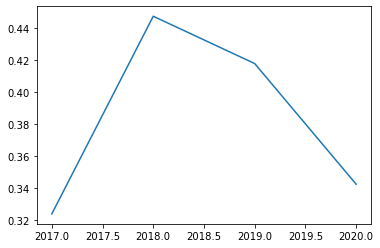

In [25]:
plt.plot(analysis["gain"])